# TASK ONE
### Before starting with Task 1.1, I will first of all load the MNIST dataset. I am using the MNIST dataset that was downloaded from the Author Nielson's Github account in Project 2. The dataset has training set, validation set and test set but since this is dimensionality reduction problem, I will combine everything into one single dataframe and call the dataframe X. I will split into training and test set whenever need arises in the project

In [95]:
# Library importation
import pandas as pd
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import mean_squared_error
from PIL import Image
import time
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [120]:
# function to load the dataset
def load_data(file_path):
    # Path to your MNIST dataset file

    # Load the MNIST dataset
    with gzip.open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')

    # Unpack the dataset (train, valid, test)
    (train_set, valid_set, test_set) = data

    # Extract features (X) and labels (y) for train, valid, and test
    X_train, y_train = train_set
    X_valid, y_valid = valid_set
    X_test, y_test = test_set

    # Combine the X (image) and y (label) from the train, valid, and test sets
    X_combined = np.concatenate((X_train, X_valid, X_test), axis=0)
    y_combined = np.concatenate((y_train, y_valid, y_test), axis=0)

    # Combine X and y into one dataframe
    # Add y as a column in the combined dataset
    df_combined = pd.DataFrame(X_combined)
    df_combined['label'] = y_combined
    return df_combined

    # Display the first few rows of the combined dataframe
    #print(df_combined.head())

In [97]:
file_path = 'data/mnist.pkl.gz'
X = load_data(file_path)

In [98]:
print(X.head())

     0    1    2    3    4    5    6    7    8    9  ...  775  776  777  778  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   779  780  781  782  783  label  
0  0.0  0.0  0.0  0.0  0.0      5  
1  0.0  0.0  0.0  0.0  0.0      0  
2  0.0  0.0  0.0  0.0  0.0      4  
3  0.0  0.0  0.0  0.0  0.0      1  
4  0.0  0.0  0.0  0.0  0.0      9  

[5 rows x 785 columns]


In [99]:
X.iloc[:,300]

0        0.000000
1        0.988281
2        0.992188
3        0.000000
4        0.082031
           ...   
69995    0.500000
69996    0.000000
69997    0.117188
69998    0.992188
69999    0.000000
Name: 300, Length: 70000, dtype: float32

In [100]:
X.shape

(70000, 785)

## TASK 1.1

### Deliverable 1: Module for Implementing FLD

In [101]:
def fld_train(X, y, num_classes=10, reg_param=1e-5):
    """
    Perform Fisher's Linear Discriminant (FLD) to reduce the dimensionality of the dataset.
    """
    # Ensure y is a 1D array
    y = y.values.flatten()  # Convert to a 1D NumPy array if y is a DataFrame

    # Check for NaN values in the input data
    if X.isnull().values.any() or pd.Series(y).isnull().any():
        raise ValueError("Input data contains NaN values.")

    n_samples, n_features = X.shape
    mean_total = np.mean(X, axis=0).values  # Convert to a NumPy array

    # Initialize the within-class and between-class scatter matrices
    S_W = np.zeros((n_features, n_features))
    S_B = np.zeros((n_features, n_features))

    for c in range(num_classes):
        # Get all the samples for class c
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0).values  # Convert mean_c to a NumPy array

        # Within-class scatter matrix
        S_W += (X_c - mean_c).T @ (X_c - mean_c)

        # Between-class scatter matrix
        n_c = X_c.shape[0]  # Number of samples in class c
        mean_diff = (mean_c - mean_total).reshape(n_features, 1)  # Reshape for matrix multiplication
        S_B += n_c * (mean_diff @ mean_diff.T)

    # Add regularization to the within-class scatter matrix to avoid singularity
    S_W += np.eye(n_features) * (reg_param + 1e-10)  # Adding a small value to prevent division by zero

    # Solve the generalized eigenvalue problem for S_W^-1 @ S_B
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_W) @ S_B)

    # Remove complex eigenvalues and corresponding eigenvectors
    eigvals = np.real(eigvals)
    eigvecs = np.real(eigvecs)

    # Sort eigenvectors by their corresponding eigenvalues in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]

    # Take the top m eigenvectors (m = num_classes - 1)
    W = eigvecs[:, :num_classes - 1]

    return W

### Deliverable 2: Standardize/Normalize the Feature

In [102]:
# function to normalize
def normalize_X(X):
    # convert to numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Compute the mean and standard deviation of each feature
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    
    # Handle the case where std_X is zero (avoid division by zero)
    std_X[std_X == 0] = 1  # This will avoid division by zero by keeping such columns unchanged

    # Normalize the features (subtract mean and divide by std deviation)
    nX = (X - mean_X) / std_X
    
    return nX

In [103]:
# Usage of the function to normalize the features.
y = X['label']
X = X.drop("label", axis = 1)
nX = normalize_X(X)
nX = pd.DataFrame(nX)

## Deliverable 3: Applying W on nX

In [104]:
W = fld_train(nX, y, num_classes=10)
print(W)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [83]:
# Using W to transform the dataset to 9 features
fX = nX @ W

In [84]:
fX.head()

0         1         2         3         4         5         6  \
0  1.144512  0.601446 -1.911625  0.197511  0.711367 -3.703581 -0.849688   
1  3.567622  3.024501 -3.332702  0.085341 -3.220888  0.483396 -0.500150   
2 -2.166913  0.056845  1.291479 -0.233045  1.009547  1.467025 -2.380522   
3 -0.601381 -3.997368 -0.039268 -0.464554 -1.608319  0.284782  0.166827   
4 -3.772875  1.563631  0.705995 -0.329904 -1.236131  1.398390  0.799693   

          7         8  
0 -1.183484 -0.507493  
1  0.602247 -0.092355  
2 -1.132495  1.505663  
3 -0.375969  0.362274  
4  1.330310 -1.015243

In [85]:
# the target variable
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: label, Length: 70000, dtype: int64

In [105]:
# function to visualize image
def visualize_class_images(X, y, img_shape=(3, 3)):
    
    # Ensure X is a NumPy array
    X = np.array(X)
    y = np.array(y)
    
    # Find one image per class (0 through 9)
    unique_classes = np.unique(y)
    fig, axes = plt.subplots(1, len(unique_classes), figsize=(2 * len(unique_classes), 2))
    
    for i, class_label in enumerate(unique_classes):
        # Get the first image from the class
        class_index = np.where(y == class_label)[0][0]  # Index of the first image with the class label
        img = X[class_index].reshape(img_shape)  # Reshape to the original image shape
        
        # Display the image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Class {class_label}')
        axes[i].axis('off')  # Hide axis ticks
    
    plt.tight_layout()
    plt.show()

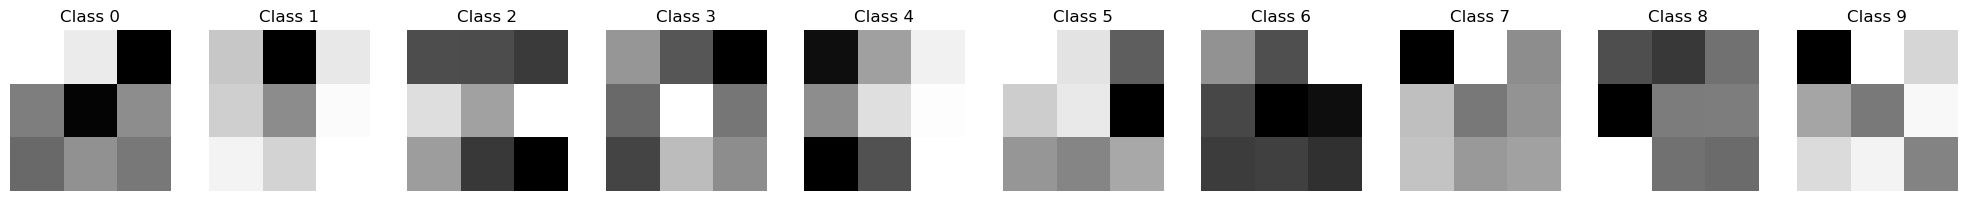

In [106]:
# Using the function to VISUALIZE COMPRESSED IMAGE
visualize_class_images(fX, y, img_shape=(3, 3)) 

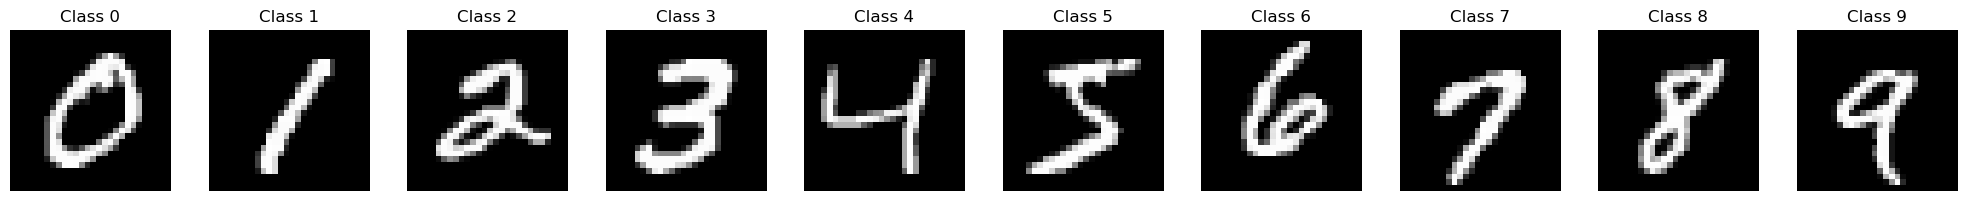

In [107]:
# Using the function to Visualize original image
visualize_class_images(X, y, img_shape=(28, 28)) 

## TASK 1.2

### Deliverable 4: Module for Implementing PCA

In [108]:
class PCA:
    def __init__(self, n_components=None, max_error_rate=None):
        """
        Initialize PCA with either a desired number of components or a desired maximum error rate.
        
        Parameters:
        - n_components: Number of principal components to keep (if specified).
        - max_error_rate: The percentage of variance we are willing to tolerate (if specified).
        """
        self.n_components = n_components
        self.max_error_rate = max_error_rate
        self.mean = None
        self.components = None
        self.explained_variance = None
        self.error_rate = None  # Store error rate after fitting
    
    def fit(self, X):
        """
        Fit the PCA model to the dataset X.
        
        Parameters:
        - X: Input data (DataFrame or NumPy array) of shape (n_samples, n_features)
        """
        # Ensure X is a NumPy array
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Step 1: Mean center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Step 2: Compute the covariance matrix
        cov_matrix = np.cov(X_centered.T)
        
        # Step 3: Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        
        # Step 4: Sort eigenvalues and corresponding eigenvectors in descending order
        sorted_idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_idx]
        eigvecs = eigvecs[:, sorted_idx]
        
        # Step 5: Compute explained variance
        total_variance = np.sum(eigvals)
        self.explained_variance = eigvals / total_variance
        
        cumulative_variance = np.cumsum(self.explained_variance)
        
        # Step 6: Select the appropriate number of components and calculate error rate
        if self.n_components is not None:
            # Use the specified number of components
            self.components = eigvecs[:, :self.n_components]
            self.error_rate = 1 - cumulative_variance[self.n_components - 1]
        elif self.max_error_rate is not None:
            # Calculate the number of components needed to meet the desired variance
            self.n_components = np.argmax(cumulative_variance >= (1 - self.max_error_rate)) + 1
            self.components = eigvecs[:, :self.n_components]
            self.error_rate = 1 - cumulative_variance[self.n_components - 1]
        else:
            raise ValueError("Either n_components or max_error_rate must be specified.")
        
        print(f"Selected components: {self.n_components}")
        print(f"Error rate (variance unexplained): {self.error_rate:.2%}")
        
        return self.n_components, self.error_rate
    
    def transform(self, X):
        """
        Transform the dataset X into the reduced dimension space using the fitted PCA model.
        
        Parameters:
        - X: Input data (DataFrame or NumPy array) of shape (n_samples, n_features)
        
        Returns:
        - X_reduced: Transformed data of shape (n_samples, n_components)
        """
        # Ensure X is a NumPy array
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Step 1: Mean center the data
        X_centered = X - self.mean
        
        # Step 2: Project the data onto the principal components
        X_reduced = np.dot(X_centered, self.components)
        
        return X_reduced


### Deliverable 5: Applying PCA to fX

In [109]:
fX.head()

0         1         2         3         4         5         6  \
0  1.144512  0.601446 -1.911625  0.197511  0.711367 -3.703581 -0.849688   
1  3.567622  3.024501 -3.332702  0.085341 -3.220888  0.483396 -0.500150   
2 -2.166913  0.056845  1.291479 -0.233045  1.009547  1.467025 -2.380522   
3 -0.601381 -3.997368 -0.039268 -0.464554 -1.608319  0.284782  0.166827   
4 -3.772875  1.563631  0.705995 -0.329904 -1.236131  1.398390  0.799693   

          7         8  
0 -1.183484 -0.507493  
1  0.602247 -0.092355  
2 -1.132495  1.505663  
3 -0.375969  0.362274  
4  1.330310 -1.015243

In [110]:
# Create a PCA instance to reduce data to 2 dimensions
pca = PCA(n_components=2)

# Fit the PCA model to the data
pca.fit(fX)

# Transform the data into the reduced dimensional space
p2fX = pca.transform(fX)
print(f"Original shape: {X.shape}")
print(f"Reduced shape: {p2fX.shape}")

Selected components: 2
Error rate (variance unexplained): 55.70%
Original shape: (70000, 784)
Reduced shape: (70000, 2)


In [111]:
p2fX = pd.DataFrame(p2fX)

In [112]:
p2fX.head()

0         1
0 -1.144520 -1.911608
1 -3.567659 -3.332651
2  2.166916  1.291489
3  0.601409 -0.039354
4  3.772865  0.706002

### Deliverable 6: Apply PCA to nX

In [113]:
nX.head()

0    1    2    3    4    5    6    7    8    9    ...       774       775  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   

        776       777       778       779  780  781  782  783  
0 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
1 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
2 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
3 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
4 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  

[5 rows x 784 columns]

In [114]:
# Create a PCA instance to reduce data to 2 dimensions
pca = PCA(n_components=2)

# Fit the PCA model to the data
pca.fit(nX)

# Transform the data into the reduced dimensional space
p2nX = pca.transform(nX)
print(f"Original shape: {X.shape}")
print(f"Reduced shape: {p2nX.shape}")

Selected components: 2
Error rate (variance unexplained): 90.32%
Original shape: (70000, 784)
Reduced shape: (70000, 2)


In [115]:
p2nX = pd.DataFrame(p2nX)

In [77]:
p2nX.head()

0         1
0 -0.891788  4.929944
1  8.813184  7.516442
2  2.205359 -9.827768
3 -6.534763  4.030233
4 -5.252019 -3.281543

### Deliverable 7: Comment
Before commenting, I will create scatter plot for both cases

In [116]:
## 2 - D Space from LDA + PCA
p2fX['label'] = y

In [92]:
p2fX.columns = ['pc1', 'pc2', 'label']

In [80]:
p2fX.head()

pc1       pc2  label
0 -1.144520 -1.911608      5
1 -3.567659 -3.332651      0
2  2.166916  1.291489      4
3  0.601409 -0.039354      1
4  3.772865  0.706002      9

<Axes: xlabel='pc1', ylabel='pc2'>

<Figure size 800x600 with 0 Axes>

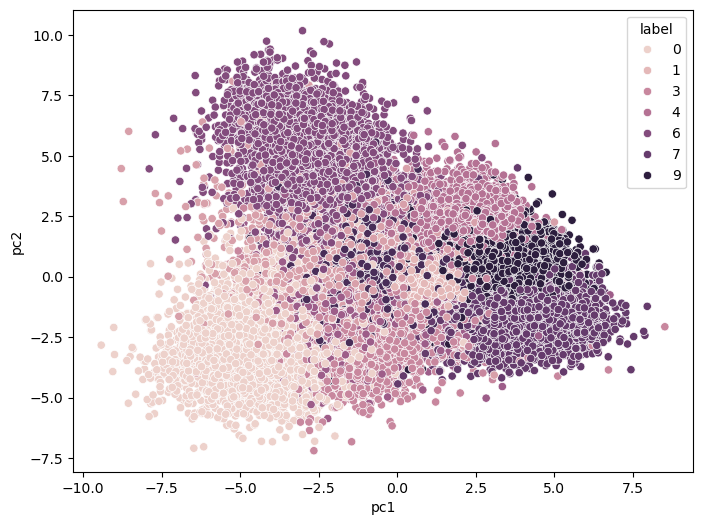

In [81]:
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.scatterplot(data=p2fX, x='pc1', y='pc2', hue='label')

In [26]:
## 2 - D Space from PCA alone
p2nX['label'] = y

In [27]:
p2nX.columns = ['pc1', 'pc2', 'label']

In [28]:
p2nX.head()

pc1       pc2  label
0 -0.891788  4.929944      5
1  8.813184  7.516442      0
2  2.205359 -9.827768      4
3 -6.534763  4.030233      1
4 -5.252019 -3.281543      9

<Axes: xlabel='pc1', ylabel='pc2'>

<Figure size 800x600 with 0 Axes>

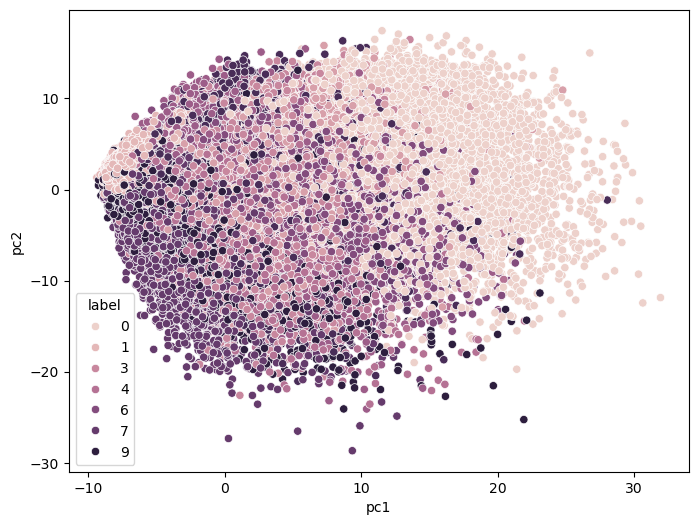

In [85]:
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.scatterplot(data=p2nX, x='pc1', y='pc2', hue='label')

### Comment: 
The visual illustration of the reduced 2-D space from FLD+PCA and from PCA are different because the use of FLD in the FLD + PCA helped to discriminate the various classes as can be seen in the scatter plot above, while in the case of 2 - D space from PCA, discrimination was not of interest as PCA only represents and not discriminate, hence, various classes are muddled together in the case of PCA as can be seen above

### Deliverable 8: Applying PCA with desired error rate

In [117]:
# Initialize PCA with a maximum error rate of 10% (90% variance retention)
pca = PCA(max_error_rate=0.1)

# Fit the PCA model to the data
n_components = pca.fit(nX)
print(f"Number of principal components selected: {n_components}")

# Transform the data into the reduced dimensional space
pX = pca.transform(nX)
print(f"Original shape: {nX.shape}")
print(f"Reduced shape: {pX.shape}")

Selected components: 238
Error rate (variance unexplained): 9.95%
Number of principal components selected: (238, 0.09954902608907479)
Original shape: (70000, 784)
Reduced shape: (70000, 238)


## TASK 1.3

### Deliverable 9: Classification Accuracy Vs PCA Error Rate


Error Rate: 5.0%
Number of Principal Components: 332, Accuracy: 95.02%

Error Rate: 10.0%
Number of Principal Components: 238, Accuracy: 95.23%

Error Rate: 15.000000000000002%
Number of Principal Components: 186, Accuracy: 95.34%

Error Rate: 20.0%
Number of Principal Components: 150, Accuracy: 95.42%

Error Rate: 25.0%
Number of Principal Components: 121, Accuracy: 95.55%

Error Rate: 30.0%
Number of Principal Components: 99, Accuracy: 95.58%


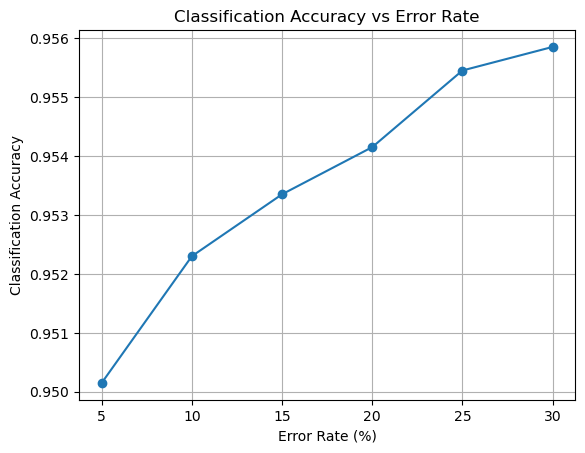

In [94]:
class PCA:
    def __init__(self, n_components=None, max_error_rate=None):
        self.n_components = n_components
        self.max_error_rate = max_error_rate
        self.mean = None
        self.components = None
        self.explained_variance = None
    
    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered.T)
        eigvals, eigvecs = np.linalg.eigh(cov_matrix)
        sorted_idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_idx]
        eigvecs = eigvecs[:, sorted_idx]
        total_variance = np.sum(eigvals)
        self.explained_variance = eigvals / total_variance
        cumulative_variance = np.cumsum(self.explained_variance)

        if self.n_components is not None:
            self.components = eigvecs[:, :self.n_components]
        elif self.max_error_rate is not None:
            self.n_components = np.argmax(cumulative_variance >= (1 - self.max_error_rate)) + 1
            self.components = eigvecs[:, :self.n_components]
        return self.n_components
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        X_centered = X - self.mean
        X_reduced = np.dot(X_centered, self.components)
        return X_reduced

# Minimum Euclidean distance classifier
def minimum_euclidean_classifier(train_data, train_labels, test_data):
    predicted_labels = []
    for test_point in test_data:
        # Calculate distances from the test point to all training points
        distances = np.linalg.norm(train_data - test_point, axis=1)
        # Get the index of the closest training point
        closest_index = np.argmin(distances)
        # Assign the label of the closest training point
        predicted_labels.append(train_labels[closest_index])
    return np.array(predicted_labels)

# Main loop to vary the error rate and perform PCA, classification, and accuracy evaluation
error_rates = np.arange(0.05, 0.35, 0.05)  # Error rates from 5% to 30%
accuracies = []

for error_rate in error_rates:
    print(f"\nError Rate: {error_rate*100}%")

    # Initialize PCA with the given error rate
    pca = PCA(max_error_rate=error_rate)

    # Fit PCA and transform the data
    n_components = pca.fit(nX)
    pX = pca.transform(nX)
    
    # Add the label column 'y' to the reduced dataset (convert y to a NumPy array first)
    pX_with_labels = np.hstack((pX, y.to_numpy().reshape(-1, 1)))

    # Split the dataset into training and testing sets
    train_data = pX_with_labels[:50000, :-1]  # First 50,000 samples for training
    train_labels = pX_with_labels[:50000, -1]
    test_data = pX_with_labels[50000:, :-1]   # Remaining samples for testing
    test_labels = pX_with_labels[50000:, -1]

    # Classify using minimum Euclidean distance
    predicted_labels = minimum_euclidean_classifier(train_data, train_labels, test_data)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    accuracies.append(accuracy)
    print(f"Number of Principal Components: {n_components}, Accuracy: {accuracy*100:.2f}%")

# Plot classification accuracy against error rate
plt.plot(error_rates * 100, accuracies, marker='o')
plt.title('Classification Accuracy vs Error Rate')
plt.xlabel('Error Rate (%)')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()

### Deliverable 10: Classification Algorithm Vs Performance Matrix Table

In [58]:
# Set batch size to process in chunks to prevent memory issues
BATCH_SIZE = 10

# Minimum Euclidean Distance Classifier with dual batch processing
def minimum_euclidean_classifier(train_data, train_labels, test_data, batch_size=BATCH_SIZE):
    n_test = test_data.shape[0]
    n_train = train_data.shape[0]
    predicted_labels = np.zeros(n_test)

    for i in range(0, n_test, batch_size):  # Process test data in chunks
        end_test_idx = min(i + batch_size, n_test)
        test_batch = test_data[i:end_test_idx]
        
        min_distances = np.full(end_test_idx - i, np.inf)  # To store the minimum distances for each test example
        best_labels = np.zeros(end_test_idx - i)           # To store the best labels for each test example

        for j in range(0, n_train, batch_size):  # Process train data in chunks
            end_train_idx = min(j + batch_size, n_train)
            train_batch = train_data[j:end_train_idx]
            
            # Compute Euclidean distances between test batch and current train batch
            distances = np.linalg.norm(test_batch[:, np.newaxis] - train_batch, axis=2)
            
            # Find the minimum distance and corresponding label
            min_indices = np.argmin(distances, axis=1)
            current_distances = np.min(distances, axis=1)
            
            # Update the best labels for each test sample
            for idx, dist in enumerate(current_distances):
                if dist < min_distances[idx]:
                    min_distances[idx] = dist
                    best_labels[idx] = train_labels[j + min_indices[idx]]

        predicted_labels[i:end_test_idx] = best_labels

    return predicted_labels

# KNN Classifier with batch processing
def knn_classifier(train_data, train_labels, test_data, k=15, batch_size=10):
    n_test = test_data.shape[0]
    predicted_labels = np.zeros(n_test)

    for i in range(0, n_test, batch_size):
        end_idx = min(i + batch_size, n_test)
        test_batch = test_data[i:end_idx]
        
        # Calculate distances between test_batch and all training samples
        distances = np.linalg.norm(test_batch[:, np.newaxis] - train_data, axis=2)
        
        # Get the indices of the k nearest neighbors
        knn_indices = np.argsort(distances, axis=1)[:, :k]
        
        # Get the labels of the k nearest neighbors
        knn_labels = train_labels[knn_indices]
        
        # Predict the label as the most common label among the k nearest neighbors
        for idx, neighbors in enumerate(knn_labels):
            predicted_labels[i + idx] = np.bincount(neighbors.astype(int)).argmax()

    return predicted_labels

# Neural Network Classifier with sigmoid activation function
def neural_network(X_train, y_train, X_test, hidden_layer_size=15, num_epochs=500, learning_rate=3):
    np.random.seed(42)
    
    # Convert y_train to integer type, if it's not already
    y_train = y_train.astype(int)
    
    n_input = X_train.shape[1]
    n_output = len(np.unique(y_train))

    # Initialize weights and biases
    W1 = 0.01 * np.random.randn(n_input, hidden_layer_size)
    b1 = np.zeros((1, hidden_layer_size))
    W2 = 0.01 * np.random.randn(hidden_layer_size, n_output)
    b2 = np.zeros((1, n_output))

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass with sigmoid activation
        hidden_layer = 1 / (1 + np.exp(-(np.dot(X_train, W1) + b1)))  # Sigmoid activation
        scores = np.dot(hidden_layer, W2) + b2

        # Softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Compute loss (Cross-Entropy)
        loss = -np.sum(np.log(probs[np.arange(len(y_train)), y_train])) / len(y_train)

        # Backpropagation
        dscores = probs
        dscores[np.arange(len(y_train)), y_train] -= 1
        dscores /= len(y_train)

        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        dhidden = np.dot(dscores, W2.T) * hidden_layer * (1 - hidden_layer)  # Gradient for sigmoid

        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)

        # Update weights
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

    # Prediction for test data
    hidden_layer = 1 / (1 + np.exp(-(np.dot(X_test, W1) + b1)))  # Sigmoid activation
    scores = np.dot(hidden_layer, W2) + b2
    predicted_labels = np.argmax(scores, axis=1)

    return predicted_labels

# Function to evaluate performance of classifiers
def evaluate_performance(X_train, y_train, X_test, y_test):
    performance_table = {}

    # Minimum Euclidean Distance Classifier
    start_time = time.time()
    predicted_labels = minimum_euclidean_classifier(X_train, y_train, X_test)
    test_time = time.time() - start_time
    accuracy = np.mean(predicted_labels == y_test)
    performance_table["Min Euclidean"] = {
        "Accuracy": accuracy,
        "Train Time": test_time,
        "Test Time": test_time
    }

    # KNN Classifier
    start_time = time.time()
    predicted_labels = knn_classifier(X_train, y_train, X_test, k=15, batch_size=10)
    test_time = time.time() - start_time
    accuracy = np.mean(predicted_labels == y_test)
    performance_table["KNN"] = {
        "Accuracy": accuracy,
        "Train Time": test_time, 
        "Test Time": test_time
    }

    # Neural Network Classifier
    start_time = time.time()
    predicted_labels = neural_network(X_train, y_train, X_test)
    test_time = time.time() - start_time
    accuracy = np.mean(predicted_labels == y_test)
    performance_table["Neural Network"] = {
        "Accuracy": accuracy,
        "Train Time": test_time,
        "Test Time": 0
    }

    # Convert performance table to DataFrame for better readability
    df_performance = pd.DataFrame.from_dict(performance_table, orient='index')
    return df_performance

### Training for the dataset nX

In [124]:
nX.head()

0    1    2    3    4    5    6    7    8    9  ...       775       776  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   

        777       778       779  780  781  782  783  label  
0 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      5  
1 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      0  
2 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      4  
3 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      1  
4 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      9  

[5 rows x 785 columns]

In [125]:
# nX with lable
nX['label'] = y
nX.head()

0    1    2    3    4    5    6    7    8    9  ...       775       776  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.023392 -0.016753   

        777       778       779  780  781  782  783  label  
0 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      5  
1 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      0  
2 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      4  
3 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      1  
4 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0      9  

[5 rows x 785 columns]

In [126]:
nX.shape

(70000, 785)

In [55]:
# function for preparing the dataset for training
def split_data(df, target_column, train_size=0.7):
    
    # Shuffle the data
    df = df.sample(frac=1).reset_index(drop=True)

    # Convert the DataFrame to a NumPy array
    data = df.to_numpy()

    # Get the index for splitting based on the train size ratio
    split_index = int(len(data) * train_size)

    # Split the data into features and labels
    X = data[:, :-1]  # All columns except the last one (assuming target is the last column)
    y = data[:, -1]   # The last column (target labels)

    # Split into training and testing sets
    X_train = X[:split_index, :]
    y_train = y[:split_index]

    X_test = X[split_index:, :]
    y_test = y[split_index:]

    return X_train, y_train, X_test, y_test

In [128]:
# Split the DataFrame into X_train, y_train, X_test, and y_test
X_train, y_train, X_test, y_test = split_data(nX, target_column='label', train_size=0.7)

# Display the result shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (49000, 784)
y_train shape: (49000,)
X_test shape: (21000, 784)
y_test shape: (21000,)


In [129]:
# Training and evaluation for nX
performance_results = evaluate_performance(X_train, y_train, X_test, y_test)
print(performance_results)

                Accuracy   Train Time    Test Time
Min Euclidean   0.943905  3670.511954  3670.511954
KNN             0.935857  4291.532395  4291.532395
Neural Network  0.935095   209.208184     0.000000


### Training for the dataset fX

In [104]:
fX.head()

0         1         2         3         4         5         6  \
0  1.144512  0.601446 -1.911625  0.197511  0.711367 -3.703581 -0.849688   
1  3.567622  3.024501 -3.332702  0.085341 -3.220888  0.483396 -0.500150   
2 -2.166913  0.056845  1.291479 -0.233045  1.009547  1.467025 -2.380522   
3 -0.601381 -3.997368 -0.039268 -0.464554 -1.608319  0.284782  0.166827   
4 -3.772875  1.563631  0.705995 -0.329904 -1.236131  1.398390  0.799693   

          7         8  
0 -1.183484 -0.507493  
1  0.602247 -0.092355  
2 -1.132495  1.505663  
3 -0.375969  0.362274  
4  1.330310 -1.015243

In [130]:
fX['label'] = y
fX.head()

0         1         2         3         4         5         6  \
0  1.144512  0.601446 -1.911625  0.197511  0.711367 -3.703581 -0.849688   
1  3.567622  3.024501 -3.332702  0.085341 -3.220888  0.483396 -0.500150   
2 -2.166913  0.056845  1.291479 -0.233045  1.009547  1.467025 -2.380522   
3 -0.601381 -3.997368 -0.039268 -0.464554 -1.608319  0.284782  0.166827   
4 -3.772875  1.563631  0.705995 -0.329904 -1.236131  1.398390  0.799693   

          7         8  label  
0 -1.183484 -0.507493      5  
1  0.602247 -0.092355      0  
2 -1.132495  1.505663      4  
3 -0.375969  0.362274      1  
4  1.330310 -1.015243      9

In [131]:
# Split the DataFrame into X_train, y_train, X_test, and y_test
X_train, y_train, X_test, y_test = split_data(fX, target_column='label', train_size=0.7)

In [132]:
# Training and evaluation for fX
# Example usage (make sure X_train, X_test, y_train, y_test are defined)
performance_results = evaluate_performance(X_train, y_train, X_test, y_test)
print(performance_results)

                Accuracy  Train Time   Test Time
Min Euclidean   0.901619  287.474365  287.474365
KNN             0.917048  122.610375  122.610375
Neural Network  0.897238   26.484895    0.000000


### Training for pX

In [133]:
pX = pd.DataFrame(pX)

In [134]:
pX.head()

0         1         2         3         4         5          6  \
0 -0.891788  4.929944 -0.094881  8.064879  0.750322  1.052788   0.283722   
1  8.813184  7.516442 -3.716833  1.765516 -0.891001 -5.108274  -0.134249   
2  2.205359 -9.827768 -5.748710 -1.480121 -4.399558  2.507937  18.931025   
3 -6.534763  4.030233  3.522734  0.217694 -5.606760  3.492868   1.443593   
4 -5.252019 -3.281543 -6.181092 -1.462288  1.668181 -0.580703  -0.565555   

          7         8         9  ...       229       230       231       232  \
0  1.423431  1.168884 -2.409498  ... -0.847661  0.865942  0.360971 -0.592895   
1  3.197415  0.237493  1.004033  ...  0.297079 -0.350460  0.347207 -0.248438   
2  3.885327 -2.446080  0.148019  ... -0.504062 -1.408405  0.269028 -1.106756   
3 -4.683225  0.614894  2.534232  ... -0.034964 -0.216473 -0.210384 -0.163170   
4 -3.129185 -0.004636  0.973645  ...  0.197497 -0.275969  0.789846 -1.145287   

        233       234       235       236       237  label  
0  1.526201  0.019428 -0.535940  1.924044 -1.783924      5  
1  0.718275 -0.520563  0.066809  0.262619 -0.220053      0  
2  0.394329  0.386375  0.627474  0.319288 -0.644044      4  
3 -0.205029 -0.272719 -0.403159  0.329395 -1.069526      1  
4  0.804500  0.874822  0.288278  0.262119 -1.054058      9  

[5 rows x 239 columns]

In [135]:
pX['label'] = y
pX.head()

0         1         2         3         4         5          6  \
0 -0.891788  4.929944 -0.094881  8.064879  0.750322  1.052788   0.283722   
1  8.813184  7.516442 -3.716833  1.765516 -0.891001 -5.108274  -0.134249   
2  2.205359 -9.827768 -5.748710 -1.480121 -4.399558  2.507937  18.931025   
3 -6.534763  4.030233  3.522734  0.217694 -5.606760  3.492868   1.443593   
4 -5.252019 -3.281543 -6.181092 -1.462288  1.668181 -0.580703  -0.565555   

          7         8         9  ...       229       230       231       232  \
0  1.423431  1.168884 -2.409498  ... -0.847661  0.865942  0.360971 -0.592895   
1  3.197415  0.237493  1.004033  ...  0.297079 -0.350460  0.347207 -0.248438   
2  3.885327 -2.446080  0.148019  ... -0.504062 -1.408405  0.269028 -1.106756   
3 -4.683225  0.614894  2.534232  ... -0.034964 -0.216473 -0.210384 -0.163170   
4 -3.129185 -0.004636  0.973645  ...  0.197497 -0.275969  0.789846 -1.145287   

        233       234       235       236       237  label  
0  1.526201  0.019428 -0.535940  1.924044 -1.783924      5  
1  0.718275 -0.520563  0.066809  0.262619 -0.220053      0  
2  0.394329  0.386375  0.627474  0.319288 -0.644044      4  
3 -0.205029 -0.272719 -0.403159  0.329395 -1.069526      1  
4  0.804500  0.874822  0.288278  0.262119 -1.054058      9  

[5 rows x 239 columns]

In [136]:
# Split the DataFrame into X_train, y_train, X_test, and y_test
X_train, y_train, X_test, y_test = split_data(pX, target_column='label', train_size=0.7)

In [137]:
# Training and evaluation for pX
# Example usage (make sure X_train, X_test, y_train, y_test are defined)
performance_results = evaluate_performance(X_train, y_train, X_test, y_test)
print(performance_results)

                Accuracy   Train Time    Test Time
Min Euclidean   0.951190  1133.445151  1133.445151
KNN             0.943524  1296.411864  1296.411864
Neural Network  0.937619    74.380373     0.000000


# TASK 2

## Image Preprocessing
The input image will be processed by reshaping the pixel data into a 2D array where each pixel is represented by its RGB values. Since the image is 1024x1024 with 3 color channels (RGB), it can be flattened into a 2D array with 1,048,576 rows and 3 columns (for the RGB values)

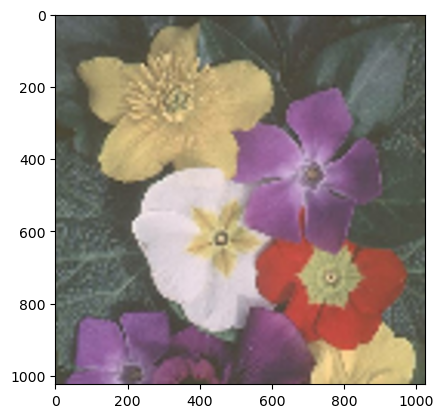

In [3]:
# Load the image using PIL and convert it to a NumPy array
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((1024, 1024))  # Ensure the image is 1024x1024
    return np.array(image)

# Convert image to a 2D array (pixels, RGB)
def preprocess_image(image):
    return image.reshape(-1, 3)  # Reshape into (number_of_pixels, 3)

# Revert compressed 2D pixels back to 3D image format
def reconstruct_image(pixels, image_shape):
    return pixels.reshape(image_shape)

# Load the image
image = load_image('flowersm.ppm')
pixels = preprocess_image(image)
plt.imshow(image)

### Deliverable 11: Implemented KNN Module for Image Compression

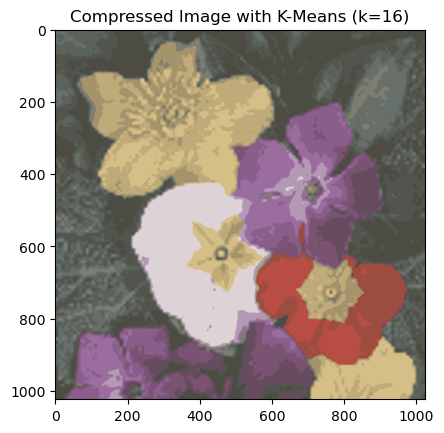

In [11]:
# K-means clustering
def kmeans(X, k, max_iters=100):
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        labels = pairwise_distances_argmin(X, centroids)
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return centroids, labels

# Compress the image using K-means
def compress_image_with_kmeans(image, k):
    pixels = preprocess_image(image)
    centroids, labels = kmeans(pixels, k)
    compressed_pixels = centroids[labels]
    return reconstruct_image(compressed_pixels, image.shape), centroids, labels

# Example usage
compressed_image_kmeans, centroids_kmeans, labels_kmeans = compress_image_with_kmeans(image, k=16)

# Display the compressed image
plt.imshow(compressed_image_kmeans.astype(np.uint8))
plt.title("Compressed Image with K-Means (k=16)")
plt.show()

### Deliverable 12: Implemeted WTA Module for Image Compression

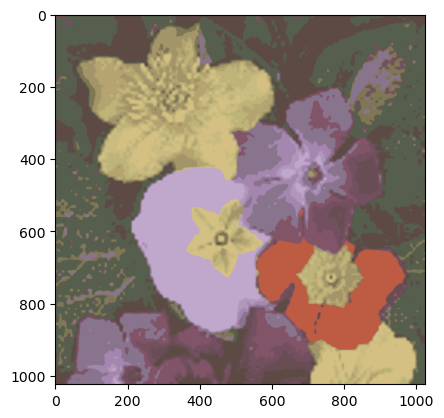

In [12]:
def wta(X, k, max_iters=100, learning_rate=0.1):
    """
    Winner-Take-All (WTA) clustering algorithm.
    
    Parameters:
    X - Input data (pixels reshaped into rows).
    k - Number of clusters (centroids).
    max_iters - Maximum number of iterations to run.
    learning_rate - The learning rate for centroid updates.
    
    Returns:
    centroids - The final centroids after clustering.
    labels - The label of the closest centroid for each data point.
    """
    # Initialize centroids randomly from the data
    centroids = X[np.random.choice(X.shape[0], k, replace=False)].astype(np.float64)  # Cast to float64
    
    for _ in range(max_iters):
        for x in X:
            # Find the closest centroid
            closest_centroid_idx = np.argmin(np.linalg.norm(x - centroids, axis=1))
            # Update the closest centroid using the learning rate
            centroids[closest_centroid_idx] += learning_rate * (x - centroids[closest_centroid_idx])
    
    # Assign labels based on the closest centroid
    labels = pairwise_distances_argmin(X, centroids)
    
    return centroids, labels

def preprocess_image(image):
    # Reshape the image into an Nx3 matrix where N is the number of pixels, and each row is an RGB triplet
    pixels = image.reshape(-1, 3)
    return pixels

def reconstruct_image(compressed_pixels, original_shape):
    # Reshape the compressed pixels back into the original image shape
    return compressed_pixels.reshape(original_shape)

# Function to perform image compression using WTA
def compress_image_with_wta(image, k):
    pixels = preprocess_image(image)
    centroids, labels = wta(pixels, k)
    compressed_pixels = centroids[labels]
    return reconstruct_image(compressed_pixels, image.shape), centroids, labels

# Example usage
compressed_image_wta, centroids_wta, labels_wta = compress_image_with_wta(image, k=16)

# Display the compressed image
plt.imshow(compressed_image_wta.astype(np.uint8))  # Ensure to cast back to uint8 for image display
plt.show()

### Deliverable 13: Plot of the Original Image

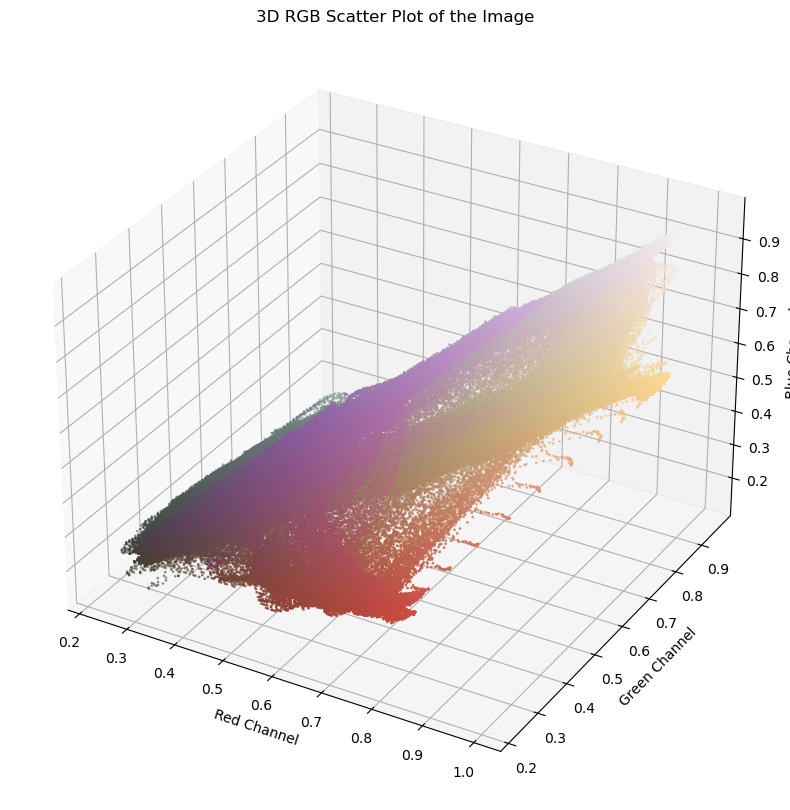

In [149]:
# Load the image using PIL and convert it to a NumPy array
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((1024, 1024))  # Ensure the image is 1024x1024
    return np.array(image)

# Generate a scatter plot of the image in 3D RGB space
def plot_rgb_scatter(image):
    # Reshape the image to a 2D array where each row is a pixel and each column is R, G, or B
    pixels = image.reshape(-1, 3)
    
    # Normalize the RGB values to [0, 1] for better visualization
    pixels_normalized = pixels / 255.0
    
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot where R, G, B are the coordinates
    ax.scatter(pixels_normalized[:, 0], pixels_normalized[:, 1], pixels_normalized[:, 2], 
               color=pixels_normalized, marker='o', s=1)
    
    # Set labels and title
    ax.set_xlabel('Red Channel')
    ax.set_ylabel('Green Channel')
    ax.set_zlabel('Blue Channel')
    ax.set_title('3D RGB Scatter Plot of the Image')
    
    plt.show()

# Load and plot the image
image = load_image('flowersm.ppm')
plot_rgb_scatter(image)

### Deliverable 14: The Table

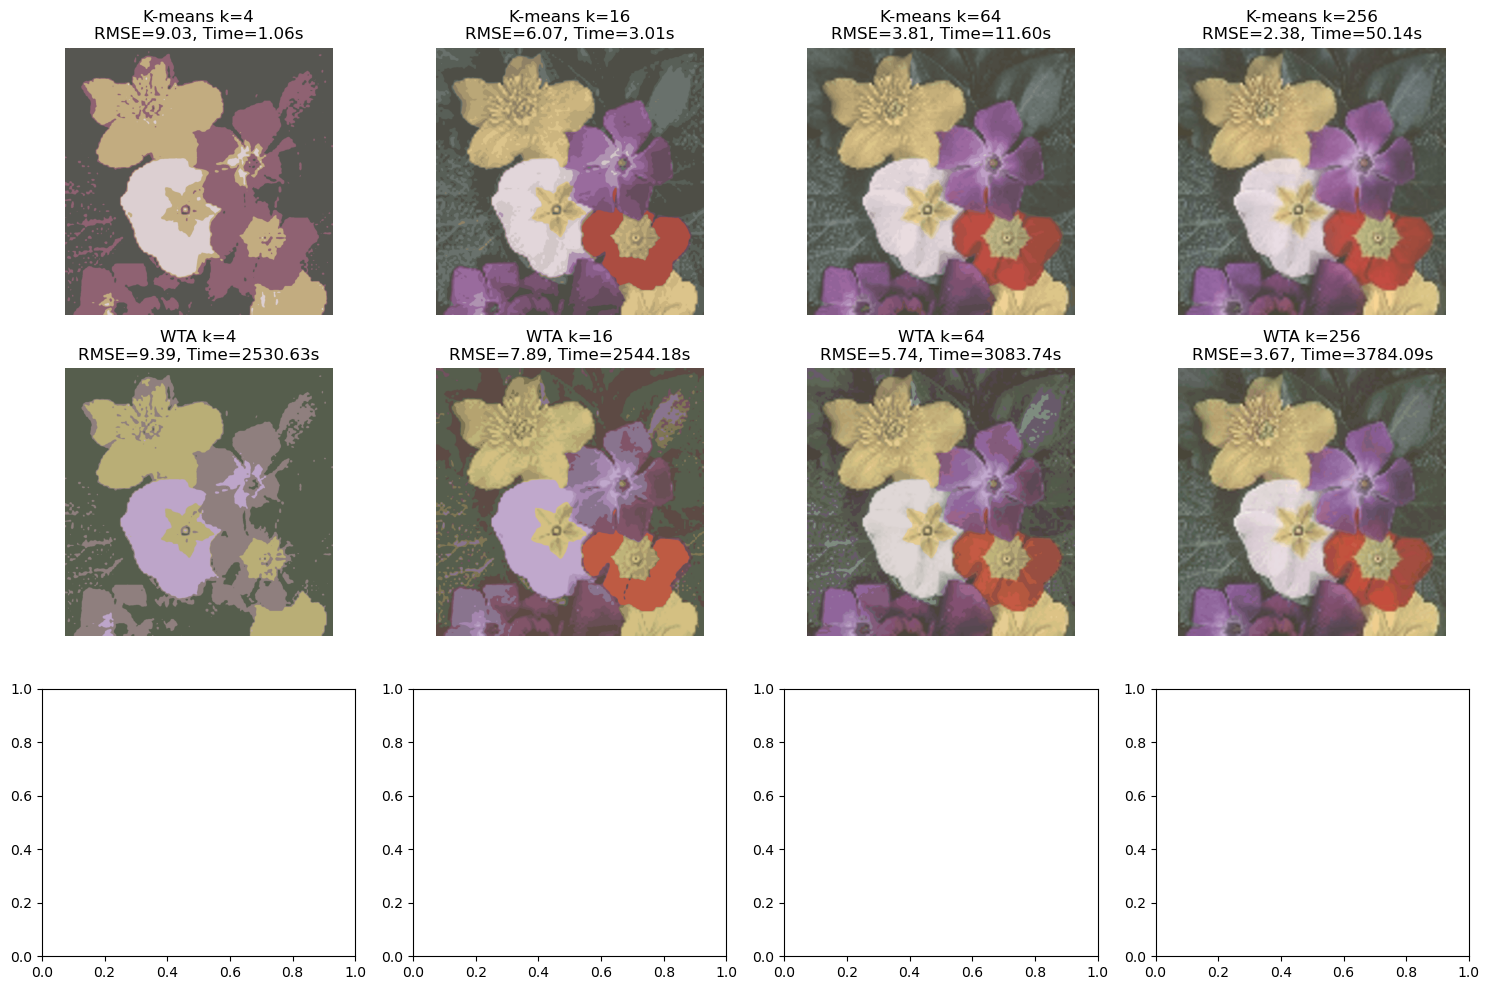

In [13]:
def kmeans_clustering(image, k):
    """
    Compress the image using K-means clustering and calculate RMSE and runtime.
    
    Parameters:`
    image - Original image as a 3D NumPy array.
    k - Number of clusters (centroids).
    
    Returns:
    compressed_image - The compressed image as a pseudo-color image.
    rmse - The RMSE between the original and pseudo-color image.
    runtime - The time taken for K-means clustering.
    """
    # Reshape image to a 2D array of pixels (number of pixels x 3)
    pixels = image.reshape(-1, 3)
    
    # Perform K-means clustering
    from sklearn.cluster import KMeans
    start_time = time.time()
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(pixels)
    runtime = time.time() - start_time
    
    # Assign cluster colors to the pixels
    pseudo_colors = kmeans.cluster_centers_.astype(np.uint8)
    compressed_image = pseudo_colors[labels].reshape(image.shape)
    
    # Calculate RMSE between original and pseudo-color image
    rmse = np.sqrt(mean_squared_error(pixels, compressed_image.reshape(-1, 3)))
    
    return compressed_image, rmse, runtime

def wta_clustering(image, k):
    """
    Compress the image using Winner-Take-All (WTA) clustering and calculate RMSE and runtime.
    
    Parameters:
    image - Original image as a 3D NumPy array.
    k - Number of clusters (centroids).
    
    Returns:
    compressed_image - The compressed image as a pseudo-color image.
    rmse - The RMSE between the original and pseudo-color image.
    runtime - The time taken for WTA clustering.
    """
    # Reshape image to a 2D array of pixels (number of pixels x 3)
    pixels = image.reshape(-1, 3)
    
    # Perform WTA clustering
    start_time = time.time()
    centroids, labels = wta(pixels, k)
    runtime = time.time() - start_time
    
    # Assign cluster colors to the pixels
    pseudo_colors = centroids.astype(np.uint8)
    compressed_image = pseudo_colors[labels].reshape(image.shape)
    
    # Calculate RMSE between original and pseudo-color image
    rmse = np.sqrt(mean_squared_error(pixels, compressed_image.reshape(-1, 3)))
    
    return compressed_image, rmse, runtime

def display_results_table(k_values, image):
    """
    Generate a table showing results for different k values using K-means and WTA.
    
    Parameters:
    k_values - List of k values (number of clusters).
    image - Original image as a 3D NumPy array.
    """
    fig, axes = plt.subplots(3, len(k_values), figsize=(15, 10))

    for i, k in enumerate(k_values):
        # K-means clustering
        compressed_image_kmeans, rmse_kmeans, time_kmeans = kmeans_clustering(image, k)
        
        # WTA clustering
        compressed_image_wta, rmse_wta, time_wta = wta_clustering(image, k)
        
        # Display K-means results
        axes[0, i].imshow(compressed_image_kmeans)
        axes[0, i].set_title(f'K-means k={k}\nRMSE={rmse_kmeans:.2f}, Time={time_kmeans:.2f}s')
        axes[0, i].axis('off')
        
        # Display WTA results
        axes[1, i].imshow(compressed_image_wta)
        axes[1, i].set_title(f'WTA k={k}\nRMSE={rmse_wta:.2f}, Time={time_wta:.2f}s')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Define k values and display the table of results
k_values = [4, 16, 64, 256]
display_results_table(k_values, image)

### Deliverable 15: Convergence Curve 

Epoch 1: 957617 samples changed membership
Centroid positions after epoch 1:
[[184.61581049 159.26216558 196.51272772]
 [140.36945579 130.59918374  92.05493153]
 [193.94044902  83.52346277  63.14956235]
 [198.74814408 103.0904017   75.87722826]
 [103.51532794  75.76173952  84.54346865]
 [ 96.58875601  76.63947465  68.5438686 ]
 [179.89349771 180.06489312 173.5008529 ]
 [174.98789874 149.29791992 184.12484436]
 [113.08341689  82.15911713  92.1037444 ]
 [194.09312188 170.33379487 206.12515468]
 [189.33242362 179.15524618 121.11847327]
 [137.23332346 117.72069908 141.19603857]
 [129.517155    83.95090546 101.88234369]
 [ 83.11393393  92.10652526  75.10530071]
 [163.95600783 137.00078732 173.64363175]
 [178.3565447  163.42551496 111.96055823]]
Epoch 2: 972944 samples changed membership
Centroid positions after epoch 2:
[[ 83.11391143  92.10516398  75.10628872]
 [163.95600783 137.00078732 173.64363175]
 [176.27281892 160.18987313 109.42149439]
 [195.14660071  91.16849213  68.48776218]
 [136

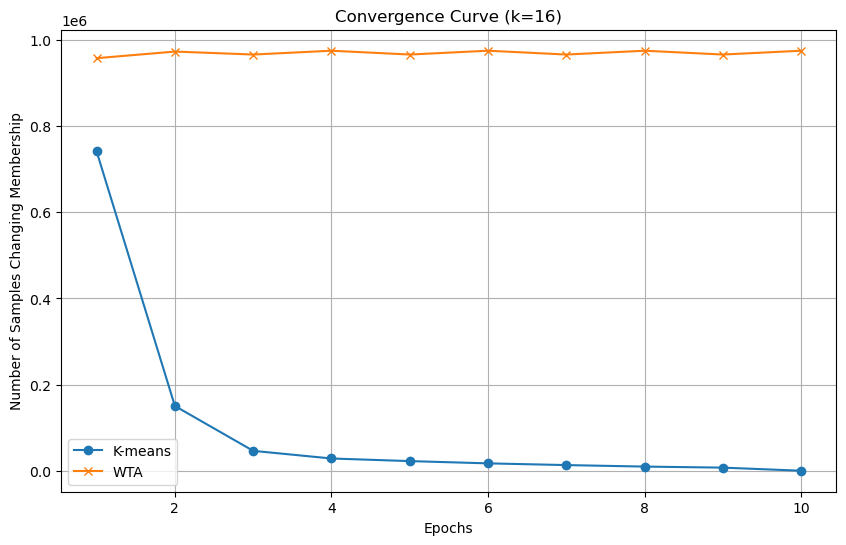

In [161]:
# KMEANS CLUSTERING

def initialize_centroids(pixels, k):
    """ Randomly initialize centroids from the pixels """
    return pixels[np.random.choice(pixels.shape[0], k, replace=False)]

def assign_clusters(pixels, centroids):
    """ Assign each pixel to the nearest centroid """
    distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(pixels, labels, k):
    """ Update centroids as the mean of all pixels in each cluster """
    centroids = np.array([pixels[labels == i].mean(axis=0) for i in range(k)])
    return centroids

def kmeans(pixels, k, max_iters=100):
    centroids = initialize_centroids(pixels, k)
    previous_labels = None
    changes = []
    
    for epoch in range(max_iters):
        labels = assign_clusters(pixels, centroids)
        centroids = update_centroids(pixels, labels, k)
        
        if previous_labels is None:
            previous_labels = labels
        else:
            # Count the number of pixels that changed their cluster assignment
            num_changed = np.sum(labels != previous_labels)
            changes.append(num_changed)
            previous_labels = labels
            
            # Stop if no pixels changed their cluster
            if num_changed == 0:
                break
                
    return centroids, labels, changes

# WINNER TAKES ALL CLUSTERING
def wta(X, k, max_iters=10, learning_rate=0.2):
    # Initialize centroids randomly, cast to float64 for precision in updates
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)].astype(np.float64)
    labels = np.zeros(X.shape[0], dtype=int)
    changes = []
    
    for epoch in range(max_iters):
        num_changed = 0
        previous_labels = labels.copy()

        # Loop over each sample
        for i, x in enumerate(X):
            # Find the closest centroid
            closest_centroid_idx = np.argmin(np.linalg.norm(x - centroids, axis=1))
            
            # Update the closest centroid with the learning rate
            centroids[closest_centroid_idx] += learning_rate * (x - centroids[closest_centroid_idx])
            
            # Assign the sample to the closest centroid
            labels[i] = closest_centroid_idx

        # Count the number of changed memberships
        num_changed = np.sum(labels != previous_labels)
        changes.append(num_changed)
        
        # Debugging: print number of changes and centroid updates
        print(f'Epoch {epoch+1}: {num_changed} samples changed membership')
        
        # Debugging: check centroid positions
        print(f'Centroid positions after epoch {epoch+1}:\n{centroids}')
        
        # Stop early if no samples change cluster assignment
        if num_changed == 0:
            break

    # Cast centroids back to uint8 for image compression (if needed)
    centroids = centroids.astype(np.uint8)
    
    return centroids, labels, changes

# PLOTTING CONVERGENCE CURVE
def plot_convergence_curve(image, k=16, max_epochs=10):
    # Preprocess the image (flattening)
    pixels = preprocess_image(image)

    # K-means Convergence
    _, _, kmeans_changes = kmeans(pixels, k, max_iters=max_epochs)

    # WTA Convergence
    _, _, wta_changes = wta(pixels, k, max_iters=max_epochs)

    # Ensure WTA changes are plotted even if the algorithm converges early
    if len(wta_changes) < max_epochs:
        wta_changes.extend([0] * (max_epochs - len(wta_changes)))

    # Ensure K-means changes are plotted even if the algorithm converges early
    if len(kmeans_changes) < max_epochs:
        kmeans_changes.extend([0] * (max_epochs - len(kmeans_changes)))

    # Plot the convergence curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(kmeans_changes) + 1), kmeans_changes, label='K-means', marker='o')
    plt.plot(range(1, len(wta_changes) + 1), wta_changes, label='WTA', marker='x')

    plt.title(f'Convergence Curve (k={k})')
    plt.xlabel('Epochs')
    plt.ylabel('Number of Samples Changing Membership')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_convergence_curve(image, k=16, max_epochs=10)

# TASK 2.2

### Deliverable 15: Deliverable 14 plus Agglomerative Hierarchical Clustering

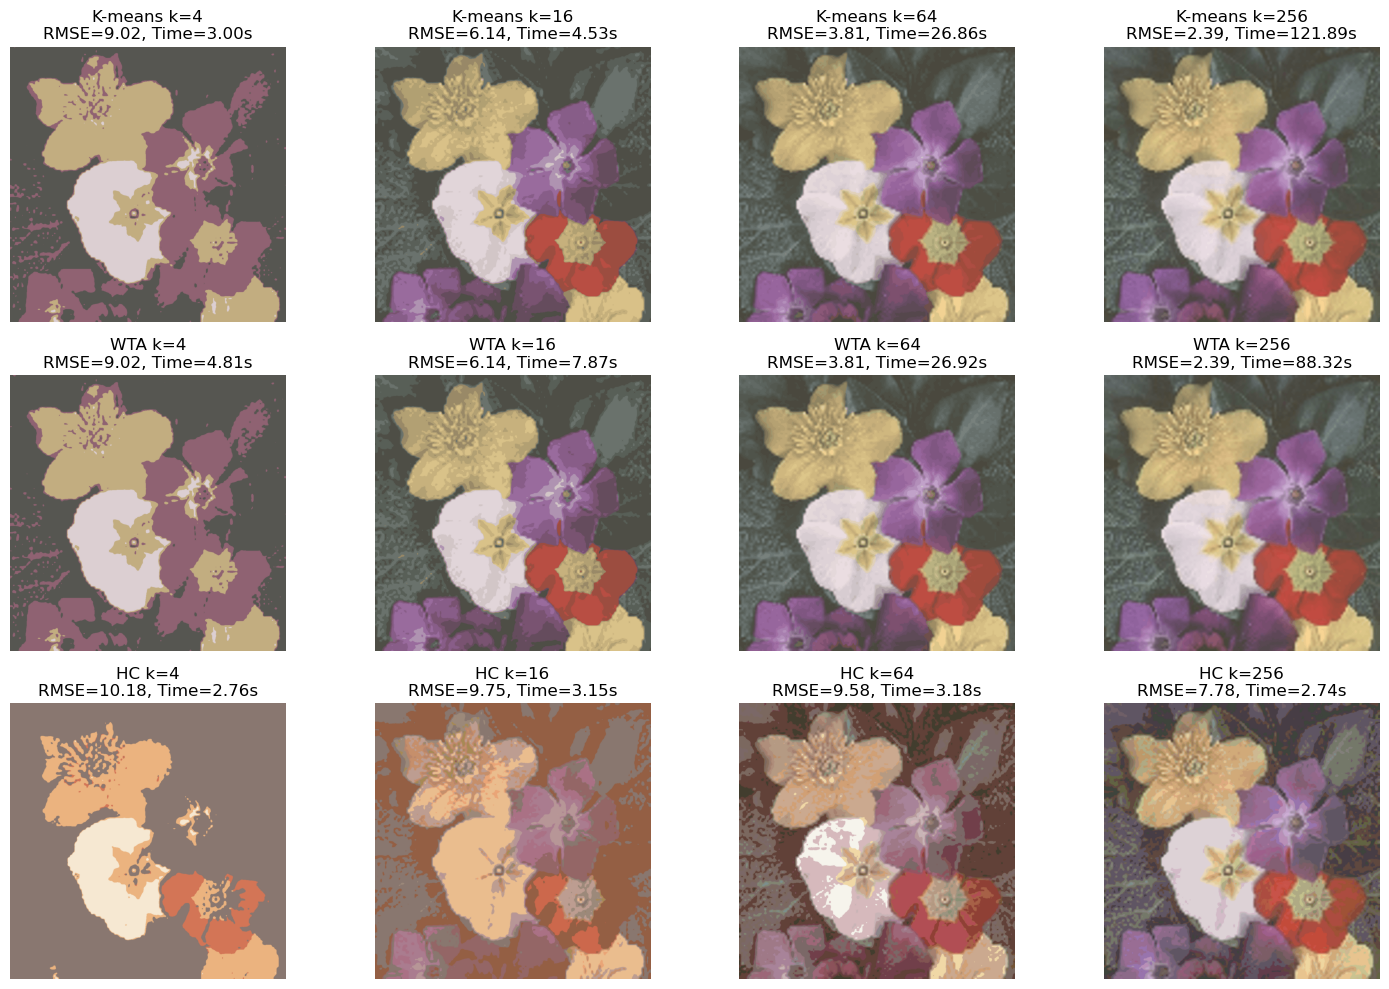

In [4]:
# Optimized WTA clustering with K-means initialization
def optimized_wta(image, k, max_iter=10):
    pixels = image.reshape(-1, 3)
    
    # Initialize centroids using KMeans for better starting points
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=0)
    kmeans.fit(pixels)
    centroids = kmeans.cluster_centers_
    
    start_time = time.time()
    for _ in range(max_iter):
        # Compute distances and update labels
        distances = cdist(pixels, centroids)
        labels = np.argmin(distances, axis=1)
        
        # Update centroids based on the assigned pixels
        for i in range(k):
            if np.any(labels == i):
                centroids[i] = pixels[labels == i].mean(axis=0)
    runtime = time.time() - start_time

    # Create compressed image
    compressed_image = centroids[labels].reshape(image.shape).astype(np.uint8)
    rmse = np.sqrt(mean_squared_error(pixels, compressed_image.reshape(-1, 3)))
    
    return compressed_image, rmse, runtime

# Optimized Hierarchical clustering on a sample subset
def optimized_hierarchical_clustering(image, k, sample_size=10000):
    pixels = image.reshape(-1, 3)

    # Random sampling for hierarchical clustering
    if pixels.shape[0] > sample_size:
        indices = np.random.choice(pixels.shape[0], sample_size, replace=False)
        sample_pixels = pixels[indices]
    else:
        sample_pixels = pixels

    # Perform hierarchical clustering
    start_time = time.time()
    hc = AgglomerativeClustering(n_clusters=k, linkage='single')
    labels_sample = hc.fit_predict(sample_pixels)
    runtime = time.time() - start_time

    # Map cluster centroids back to full image
    centroids = np.array([sample_pixels[labels_sample == i].mean(axis=0) for i in range(k)])
    full_distances = cdist(pixels, centroids)
    full_labels = np.argmin(full_distances, axis=1)

    compressed_image = centroids[full_labels].reshape(image.shape).astype(np.uint8)
    rmse = np.sqrt(mean_squared_error(pixels, compressed_image.reshape(-1, 3)))
    
    return compressed_image, rmse, runtime

# K-means clustering using scikit-learn
def kmeans_clustering(image, k):
    pixels = image.reshape(-1, 3)
    
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(pixels)
    runtime = time.time() - start_time

    # Map cluster centroids back to image
    pseudo_colors = kmeans.cluster_centers_.astype(np.uint8)
    compressed_image = pseudo_colors[labels].reshape(image.shape)
    
    rmse = np.sqrt(mean_squared_error(pixels, compressed_image.reshape(-1, 3)))
    
    return compressed_image, rmse, runtime

# Function to display results in a 3x4 grid
def display_results_table(k_values, image):
    fig, axes = plt.subplots(3, len(k_values), figsize=(15, 10))
    
    for i, k in enumerate(k_values):
        # K-means clustering
        compressed_image_kmeans, rmse_kmeans, time_kmeans = kmeans_clustering(image, k)
        
        # WTA clustering
        compressed_image_wta, rmse_wta, time_wta = optimized_wta(image, k)
        
        # Hierarchical clustering
        compressed_image_hc, rmse_hc, time_hc = optimized_hierarchical_clustering(image, k)
        
        # Display K-means results
        axes[0, i].imshow(compressed_image_kmeans)
        axes[0, i].set_title(f'K-means k={k}\nRMSE={rmse_kmeans:.2f}, Time={time_kmeans:.2f}s')
        axes[0, i].axis('off')
        
        # Display WTA results
        axes[1, i].imshow(compressed_image_wta)
        axes[1, i].set_title(f'WTA k={k}\nRMSE={rmse_wta:.2f}, Time={time_wta:.2f}s')
        axes[1, i].axis('off')
        
        # Display Hierarchical clustering results
        axes[2, i].imshow(compressed_image_hc)
        axes[2, i].set_title(f'HC k={k}\nRMSE={rmse_hc:.2f}, Time={time_hc:.2f}s')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Define k values and display the table of results
k_values = [4, 16, 64, 256]
display_results_table(k_values, image)

### Deliverable 16: Comments on Pros and Cons

### Image Quality:
In terms of image quality, hierarchical clustering gave the worst performance while Kmeans and WTA have almost the same quality
### Runtime:
There is no much significant difference in runtime but hierarchical clustering gave the best performance in terms of runtime, followed by WTA
### RMSE:
For RMSE, Kmeans and WTA have almost same performance and they outperformed hierarchical clustering
### Overall Performance:
Overall, I will chose any of Kmeans and WTA because they performed far better in terms of image quality and not badly in terms of runtime and RMSE


# TASK 2.3 (BONUS)

### Deliverable 17

In [118]:
nX.head()

0    1    2    3    4    5    6    7    8    9    ...       774       775  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.032962 -0.023392   

        776       777       778       779  780  781  782  783  
0 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
1 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
2 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
3 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  
4 -0.016753 -0.010638 -0.008339 -0.005342  0.0  0.0  0.0  0.0  

[5 rows x 784 columns]

In [119]:
# Initialize PCA with a maximum error rate of 10% (90% variance retention)
pca = PCA(max_error_rate=0.1)

# Fit the PCA model to the standardized MNIST dataset
n_components = pca.fit(nX)
print(f"Number of principal components selected: {n_components}")

# Transform the data into the reduced dimensional space
X_transformed = pca.transform(nX)
print(f"Original shape: {nX.shape}")
print(f"Reduced shape: {X_transformed.shape}")

Selected components: 238
Error rate (variance unexplained): 9.95%
Number of principal components selected: (238, 0.09954902608907479)
Original shape: (70000, 784)
Reduced shape: (70000, 238)


#### As seen above, with 10% error rate, PCA would reduce the dimension from 784 to 238” Hence, I used SLINK to group features into 238 clusters and plotted the dendrogram as seen below.

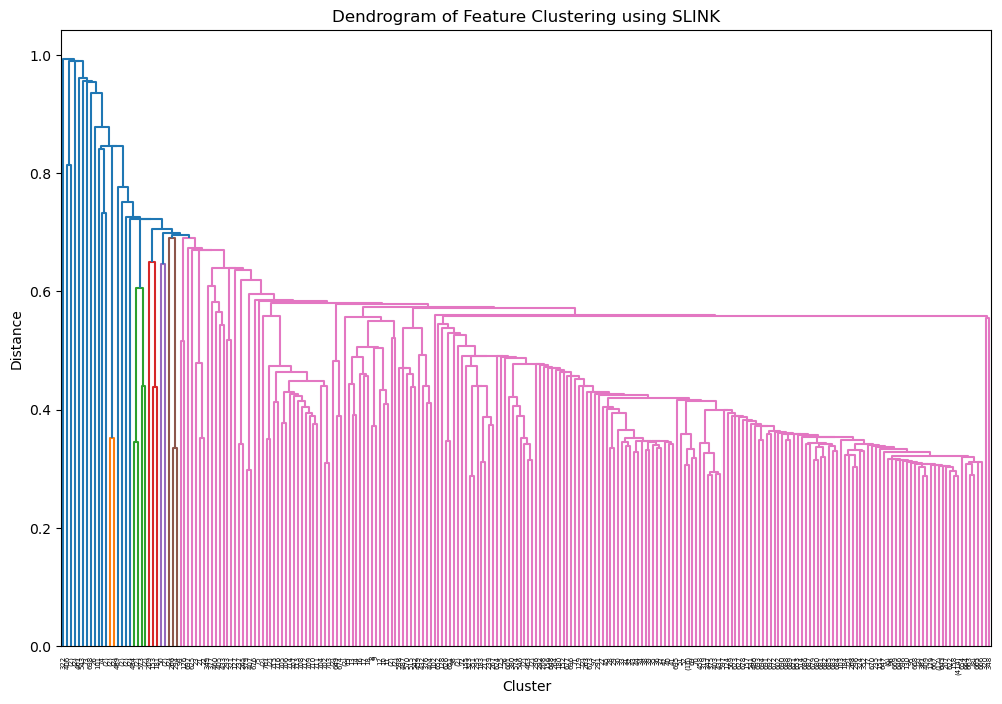

Reduced DataFrame with 238 features


In [70]:
# Step 1: Remove constant (zero variance) features
X = nX.loc[:, X.var() != 0]

# Step 2: Calculate the similarity (distance) matrix between features
feature_distances = np.corrcoef(X.T)
distance_matrix = 1 - feature_distances
distance_matrix = np.nan_to_num(distance_matrix, nan=1.0)

# Step 3: Apply SLINK (single linkage clustering) using scipy
flattened_distance_matrix = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
Z = linkage(flattened_distance_matrix, method='single')

# Step 4: Generate 238 clusters from the linkage matrix
num_clusters = 238
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# Step 5: Aggregate features within each cluster efficiently
clustered_features = {}  # Dictionary to store each cluster's aggregated feature
for cluster_num in range(1, num_clusters + 1):
    feature_indices = np.where(clusters == cluster_num)[0]
    clustered_features[f'cluster_{cluster_num}'] = X.iloc[:, feature_indices].mean(axis=1)

# Convert dictionary to DataFrame all at once
X_reduced = pd.DataFrame(clustered_features)

# Step 6: Optional - Plot dendrogram to visualize the clustering
plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='lastp', p=num_clusters)
plt.title('Dendrogram of Feature Clustering using SLINK')
plt.xlabel('Cluster')
plt.ylabel('Distance')
plt.show()

# X_reduced now has 238 aggregated features
print("Reduced DataFrame with", X_reduced.shape[1], "features")


## Deliverable 18: Classification Performance Comparison
As can be seen below, classification performance for the dataset resulting from clustering of the features using SLINK is significantly less than the accuracy achieved for datasets resulting from other dimensionality reduction approach seen above. This implies that the use of Agglomerative Hierarchical Clustering for dimensionality reduction is not the best choice

In [71]:
X_reduced.head()

cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  \
0  -0.004098   -0.00378   -0.00378  -0.004375  -0.007188  -0.011247   
1  -0.004098   -0.00378   -0.00378  -0.004375  -0.007188  -0.011247   
2  -0.004098   -0.00378   -0.00378  -0.004375  -0.007188  -0.011247   
3  -0.004098   -0.00378   -0.00378  -0.004375  -0.007188  -0.011247   
4  -0.004098   -0.00378   -0.00378  -0.004375  -0.007188  -0.011247   

   cluster_7  cluster_8  cluster_9  cluster_10  ...  cluster_229  cluster_230  \
0   -0.00378  -0.004709   -0.00378    -0.00378  ...    -0.005157    -0.009648   
1   -0.00378  -0.004709   -0.00378    -0.00378  ...    -0.005157    -0.009648   
2   -0.00378  -0.004709   -0.00378    -0.00378  ...    -0.005157    -0.009648   
3   -0.00378  -0.004709   -0.00378    -0.00378  ...    -0.005157    -0.009648   
4   -0.00378  -0.004709   -0.00378    -0.00378  ...    -0.005157    -0.009648   

   cluster_231  cluster_232  cluster_233  cluster_234  cluster_235  \
0    -0.006076     -0.00378     -0.00789     -0.00378     -0.00378   
1    -0.006076     -0.00378     -0.00789     -0.00378     -0.00378   
2    -0.006076     -0.00378     -0.00789     -0.00378     -0.00378   
3    -0.006076     -0.00378     -0.00789     -0.00378     -0.00378   
4    -0.006076     -0.00378     -0.00789     -0.00378     -0.00378   

   cluster_236  cluster_237  cluster_238  
0    -0.005345    -0.005468     -0.00378  
1    -0.005345    -0.005468     -0.00378  
2    -0.005345    -0.005468     -0.00378  
3    -0.005345    -0.005468     -0.00378  
4    -0.005345    -0.005468     -0.00378  

[5 rows x 238 columns]

In [73]:
# adding label
X_reduced['label'] = y

In [74]:
# Split the DataFrame into X_train, y_train, X_test, and y_test
X_train, y_train, X_test, y_test = split_data(X_reduced, target_column='label', train_size=0.7)

In [75]:
# Training and evaluation for nX
# Example usage (make sure X_train, X_test, y_train, y_test are defined)
performance_results = evaluate_performance(X_train, y_train, X_test, y_test)
print(performance_results)

                Accuracy   Train Time    Test Time
Min Euclidean   0.437190  2566.673688  2566.673688
KNN             0.522190  2477.134713  2477.134713
Neural Network  0.532571   158.483566     0.000000
